In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from keras import metrics
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer

# Hyperparameters

In [2]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 280
validation_triplets = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

# Creating training dataset from generator 

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [4]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(100, 100, 3)


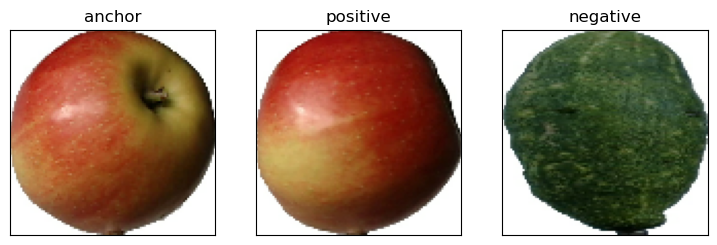

In [5]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

(100, 100, 3)


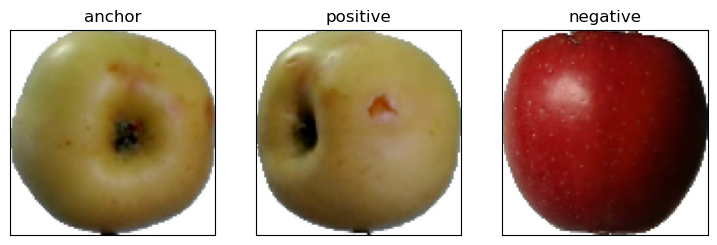

In [6]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Creating siamese model

In [7]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [8]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Compilation of our model and summary

In [9]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

# Training 

In [10]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset)

Epoch 1/10
     18/Unknown 5s 128ms/step - loss: 0.1782

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.1766 - val_loss: 0.0586
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0383 - val_loss: 0.0459
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0368 - val_loss: 0.0848
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0715 - val_loss: 0.0598
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0455 - val_loss: 0.0146
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0562 - val_loss: 0.0113
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0534 - val_loss: 0.0149
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0454 - val_loss: 0.0239
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0158 - val_loss: 0.0576
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0392 - val_loss: 0.0354


# Visualizing the next triplet

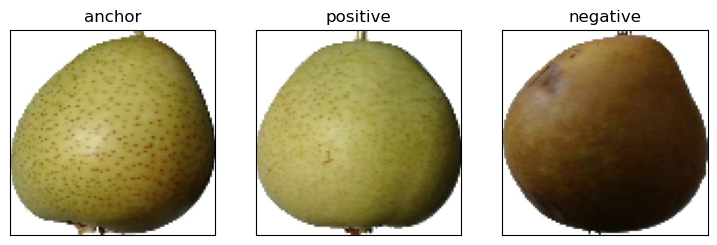

In [11]:
sample = next(iter(training_dataset))
anchor_img = np.asarray(sample[0][0]).astype('float32')
positive_img = np.asarray(sample[1][0]).astype('float32')
negative_img = np.asarray(sample[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})

# Evaluating the cosine similarity on trained model

In [12]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative),
)
cosine_similarity = metrics.CosineSimilarity()

# Positive similarity should be larger than negative similarity
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.96281046
Negative similarity 0.7926315
